# AIR PARADIS

Air Paradis veut un prototype d’un produit IA permettant de prédire le sentiment associé à un tweet.

Description des données : (pas de données chez Air Paradis), mais utiliser des données open source

- des informations sur les tweets (utilisateur ayant posté, contenu, moment du post) 
- un label binaire (tweet exprimant un sentiment négatif ou non). 



TO-DO :
- préparer un prototype fonctionnel du modèle. Le modèle envoie un tweet et récupère la prédiction de sentiment. 
- préparer un support de présentation explicitant la méthodologie utilisée pour l’approche “modèle sur mesure avancé” (attention : audience non technique)



### Tester plusieurs approches

- approche “**API sur étagère**” en utilisant l’API du `service cognitif` proposé par `Microsoft Azure pour l’analyse de sentiment`. Vu le coût de ce service, ne le teste pas sur toute la base mais uniquement sur un ensemble de tests de quelques milliers d’exemples représentatifs de l’ensemble des données.

- approche “**Modèle sur mesure simple**” en utilisant le `service Azure Machine Learning Studio` (classic), interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.

- approche “**Modèle sur mesure avancé**” en utilisant le service `Azure Machine Learning` pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet. => C’est ce modèle que tu pourras déployer et montrer à Air Paradis.

# Data Information
Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

*Content*
It contains the following 6 fields:

- `target`: the polarity of the tweet (0 = negative, 4 = positive)

- `ids`: The id of the tweet ( 2087)

- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.

- `user`: the user that tweeted (robotickilldozr)

- `text`: the text of the tweet (Lyx is cool)

In [3]:
# import Azure SDK libraries
import azureml
from azureml.core import Workspace
from azureml.core import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

# 0.1. CREATE AZURE WORKSPACE

Since we are going to train some of our model on Azure, we are going to start the projet by creating a workspace on Azure. 


In [148]:
# reuse the Workspac we have already crated
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: openclassroomws
Azure region: eastus2
Subscription id: b7ff1da8-65bd-4db1-b5db-e88f05415e38
Resource group: kba-grp


**Below the code to create the workspace.
Not to be run, since the workspace is already created**

# 0.1. READ TWEET DATA

This is the **sentiment140** dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

*Content*
It contains the following 6 fields:

- `target`: the polarity of the tweet (0 = negative, 4 = positive)

- `ids`: The id of the tweet ( 2087)

- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.

- `user`: the user that tweeted (robotickilldozr)

- `text`: the text of the tweet (Lyx is cool)

In [4]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import pandas as pd 
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split


In [5]:
col=['target','ids','date','flag','user','text']
data =pd.read_csv("data/training.1600000.processed.noemoticon.csv", header=None)

In [6]:
data.columns=col
df=data[['target', 'text']].copy()
# change the modality 4 to 1
df['target']=np.where(df.target==4, 1, df.target)

In [7]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## 0.1.1. CREATE DATASETS FOR TRAINING AND TESTING

For the sake of conformity and compue resource constraint we are going to use a training set 1600 rows for training and then 1600 rows of data for tesing.

We, in the cell blow, create our two datasets for good. 
- The training set is going to be used for all models that we are going to create. 
- The testing set is going to used with all models to ensure conformity or comparabily.

In [182]:
# create 1600 for training
df_training=df.sample(3200, random_state=49)
# create 1600 for testing
df_testing=df_training.iloc[1600:,:]
df_training=df_training.iloc[:1600,:]

print("the shape for training data", df_training.shape )
print("the shape for testing data", df_testing.shape)

# save it to csv to ensure consistency

df_training.to_csv("data/train_sentiment1600.csv", index=False)

df_testing.to_csv("data/test_sentiment1600.csv", index=False)

the shape for training data (1600, 2)
the shape for testing data (1600, 2)


In [183]:
# Now let's read from there
df_train=pd.read_csv("data/train_sentiment1600.csv")[["target", "text"]]

df_test=pd.read_csv("data/test_sentiment1600.csv")[["target", "text"]]

In [184]:
df_train.shape, df_test.shape

((1600, 2), (1600, 2))

In [185]:
df_test.head()

,target,text
0,0,Found out today the Pepsi Throwback line gets ...
1,1,"@draconum Hahah, brings one back to one's root..."
2,1,@earAsol :-/ sorry about that... hope you feel...
3,0,Just got done with my lit final! Now studying ...
4,0,@schuppette Doesnt anyone have any sympathy? I...


In [186]:
df_train.head()

,target,text
0,1,@snarkandboobs LOL at your last tweet. BTW-our...
1,0,Kasabian tomorrow....I can't be excited until ...
2,1,Gonna hit the hay soon!!nighty night all
3,1,@ffyza : omg u r in tution class with chips? i...
4,1,"oliceo.fr in progress, chaud devant"


## 0.1.2. CLEAN THE TEXT DATASETS
In this step we are going to clean our datasets:
- Remove URLS, @, # and so on
- try to correct for spells

And then apply some recommended text transformation or pretraitement:
- Lemmatizing
- Stemming
- Cleaning for stopwords


In [46]:
# create stemming ds on training set
# create lemmatizing ds on training set

In [187]:
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk import PorterStemmer , WordNetLemmatizer, word_tokenize
import re
#!pip install pyspellchecker
from spellchecker import SpellChecker
import string
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = stopwords.words("english")


# stemming
stem=EnglishStemmer()
# lemmatizing
lemma=WordNetLemmatizer()

def parseLemmatizeOrStem(text, lemmatize=True):

    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub('\S*@\S*\s?', '', text)  # remove emails
    text = re.sub('\s+', ' ', text)         # remove newline chars
    text = re.sub("\'", "", text)          # remove single quotes
    
    # tokenize
    text_token = word_tokenize(text)
    # lower case
    text_token=[x.lower() for x in text_token ]
    # Lemmatizing or stemming
    if lemmatize:
        text_los=[lemma.lemmatize(x).lower() for x in text_token]
    else:
        text_los=[stem.stem(x).lower() for x in text_token]
    # stop_words
    stop_words=nltk.corpus.stopwords.words("english")
    swords = set(stop_words)
    text_stop = [w for w in text_los if w not in swords]    
    # join words as sentence like list
    text = " ".join(text_stop)
    return text


def applyLemmOrStemm(text, lemmatize=True):
    
    # tokenize
    text_token = word_tokenize(text)
    # lower case
    text_token=[x.lower() for x in text_token ]
    # Lemmatizing or stemming
    if lemmatize:
        text_los=[lemma.lemmatize(x).lower() for x in text_token]
    else:
        text_los=[stem.stem(x).lower() for x in text_token]
      
    # join words as sentence like list
    text = " ".join(text_los)
    return text


def cleanOnly(text):

    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub('\S*@\S*\s?', '', text)  # remove emails
    text = re.sub('\s+', ' ', text)         # remove newline chars
    text = re.sub("\'", "", text)          # remove single quotes
    
    text_token = word_tokenize(text)
    text_token=[x.lower() for x in text_token ]
    # stop_words
    stop_words=nltk.corpus.stopwords.words("english")
    swords = set(stop_words)
    text_stop = [w for w in text_token if w not in swords]
    
    # join words as sentence like list
    text = " ".join(text_stop)
    return text

def applyLemOrStemOnDF(df_test):
    X=df_test.text.values
    y=df_test.target.values
    X_test =[]
    X_test_lemma =[]
    X_test_stemm =[] 
    for i in X.tolist() :
        X_test_lemma.append(applyLemmOrStemm(i, lemmatize=True))
        X_test_stemm.append(applyLemmOrStemm(i, lemmatize=False))
    return X_test_lemma, X_test_stemm

spell = SpellChecker()
def correct_spellings(x, spell=spell):
    """correct the missplled words of a given tweet"""
    x = x.split()
    misspelled = spell.unknown(x)
    result = map(lambda word : spell.correction(word) if word in  misspelled else word, x)
    return " ".join(result)

def tweets_cleaning(x, correct_spelling=True, remove_emojis=True, remove_stop_words=True):
    """Apply function to a clean a tweet"""
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # remove punctuation
    operator = str.maketrans('','',string.punctuation) #????
    x = x.translate(operator)
    if correct_spelling:
        x = correct_spellings(x)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

# REF : for the last function tweet_cleaning,
#https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

[nltk_data] Downloading package stopwords to /Users/kindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [188]:
df_train.text[0]

'@snarkandboobs LOL at your last tweet. BTW-our friends @CollegePolitico &amp; @MediaLizzy were great guests on Unusable Signal BTR show 2nite '

In [189]:
## APPLY the cleaning function to the text column
df_train['text']=df_train['text'].apply(tweets_cleaning)
df_test['text']=df_test['text'].apply(tweets_cleaning)

In [191]:
df_train.text[0]

'snarkandboobs lol last tweet tour friends collegepolitico amp medializzy great guests unusable signal bar show unite'

In [192]:
# CREATE TRAIN and TEST SET
Xtrain=df_train.text.values
ytrain=df_train.target.values

Xtest=df_test.text.values
ytest=df_test.target.values

In [193]:
# TRAIN SET WITHOUT LEMMATIZING AND STEMMING
X_train_ds=Xtrain
X_test_ds=Xtest

In [194]:
# APPPLY LEMMATIZATION AND STEMMING ON THE TRAINING SET
X_train_lem_ds, X_train_stem_ds = applyLemOrStemOnDF(df_train)

In [195]:
#  APPPLY LEMMATIZATION AND STEMMING ON THE TESTING SET
X_test_lem_ds, X_test_stem_ds = applyLemOrStemOnDF(df_test)

In [196]:
#X_lem_ds.shape, X_stem_ds.shape

print(X_train_ds[:1])
print()
print(X_train_lem_ds[:1])
print()
print(X_train_stem_ds[:1])

['snarkandboobs lol last tweet tour friends collegepolitico amp medializzy great guests unusable signal bar show unite']

['snarkandboobs lol last tweet tour friend collegepolitico amp medializzy great guest unusable signal bar show unite']

['snarkandboob lol last tweet tour friend collegepolitico amp medializzi great guest unus signal bar show unit']


# 1. TEXT ANALYTICS

Creation the language service from the pack of Cognitive Services on Azure. And then with the text analytics API keys and Endpoints we can directly from our notebook score the all tweets on our texting set and compute accuracy.

The API provides a `neutral` score on top of `positive and negative` score. Since our data has only two scores, what can we do about it? we dealt with it in two ways :
- ignore the neutral score and use only positive and negative to compute our accuracy score for the texts analytics API on our testing set
- replace it whenever it appears by the max of its associated positive and negative score for the same input text. 

The latter methode increases the accuracy of our testing set.

In [197]:
# LIBRAIRIES FROM AZURE SDK
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

In [198]:
# SOME UTILS FUNCTION 
def sentimenta_pred(tweet_string):
    
    tweet_string_to_list=[]
    tweet_string_to_list.append(tweet_string)
    
    response = text_analytics_client.analyze_sentiment(tweet_string_to_list, language="en")
    
    result = [doc for doc in response if not doc.is_error]
    
    for doc in result:
            scores=[doc.confidence_scores.positive,
                    doc.confidence_scores.neutral,
                    doc.confidence_scores.negative]
            return doc.sentiment
            #if  np.max(scores) > 0.5 :
             #   return 1
            #else :
             #   return 0
                
def sentimenta_score_neutral(tweet_string):
    
    tweet_string_to_list=[]
    tweet_string_to_list.append(tweet_string)
    
    response = text_analytics_client.analyze_sentiment(tweet_string_to_list, language="en")
    
    result = [doc for doc in response if not doc.is_error]
    
    for doc in result:
        if doc.sentiment=='positive':
            return doc.confidence_scores.positive
        elif doc.sentiment=='negative':
            return doc.confidence_scores.negative
        elif doc.sentiment=='neutral':
            return doc.confidence_scores.neutral
        
def sentimenta_score(tweet_string):
    
    tweet_string_to_list=[]
    tweet_string_to_list.append(tweet_string)
    
    response = text_analytics_client.analyze_sentiment(tweet_string_to_list, language="en")
    
    result = [doc for doc in response if not doc.is_error]
    
    for doc in result:
        if doc.sentiment=='positive':
            return doc.confidence_scores.positive
        elif doc.sentiment=='negative':
            return doc.confidence_scores.negative
        elif doc.sentiment=='neutral':
            a= float(doc.confidence_scores.positive)
            b= float(doc.confidence_scores.negative)
            return max(a, b)
    
    
def sentimenta_pred_score(tweet_string):
    
    tweet_string_to_list=[]
    tweet_string_to_list.append(tweet_string)
    
    response = text_analytics_client.analyze_sentiment(tweet_string_to_list, language="en")
    
    result = [doc for doc in response if not doc.is_error]
    
    for doc in result:
        if doc.sentiment=='positive':
            return doc.sentiment
        elif doc.sentiment=='negative' :
            return doc.sentiment
        else :
            if doc.confidence_scores.positive > doc.confidence_scores.negative:
                return 'positive'
            else :
                return 'negative'


In [199]:
credential = AzureKeyCredential("1f74e478569e4d0295e95c68cab30fac")
endpoint="https://openclassrooms.cognitiveservices.azure.com/"

# intantiation
text_analytics_client = TextAnalyticsClient(endpoint=endpoint,
                                            credential=credential)

In [200]:
# TEST THE ENDPOINT 
documents = [
    "I did not like the restaurant. The food was somehow both too spicy and underseasoned. Additionally",
    "I thought the location was too far away from the playhouse.",
    "The restaurant was decorated beautifully. The atmosphere was unlike any other restaurant I've been to.",
    "The food was yummy. :)" ]

response = text_analytics_client.analyze_sentiment(documents, language="en")
result = [doc for doc in response if not doc.is_error]

for doc in result:
    print("Overall sentiment: {}".format(doc.sentiment))
    print("Scores: positive={}; neutral={}; negative={} \n".format(
        doc.confidence_scores.positive,
        doc.confidence_scores.neutral,
        doc.confidence_scores.negative,
    ))

Overall sentiment: negative
Scores: positive=0.01; neutral=0.23; negative=0.76 

Overall sentiment: negative
Scores: positive=0.0; neutral=0.02; negative=0.98 

Overall sentiment: positive
Scores: positive=1.0; neutral=0.0; negative=0.0 

Overall sentiment: positive
Scores: positive=0.94; neutral=0.05; negative=0.01 



In [201]:
# READ THE TEST DATA CONTAINING 1000 TWEETS
df_tweet=pd.read_csv("data/test_sentiment1600.csv")[["target", "text"]]
print(df_tweet.shape)

(1600, 2)


In [202]:
df_tweet.head(3)

,target,text
0,0,Found out today the Pepsi Throwback line gets ...
1,1,"@draconum Hahah, brings one back to one's root..."
2,1,@earAsol :-/ sorry about that... hope you feel...


In [ ]:
# SCORE THE TESTING DATASET

In [203]:
pred_azure_score = []
pred_azure_sent = []

pred_azure_sent_correct = []
pred_azure_score_correct = []

tweet_string=df_tweet.text.to_list()

for tweet in tweet_string:
    pred_azure_score.append(sentimenta_score_neutral(tweet))
    pred_azure_sent.append(sentimenta_pred(tweet))
    pred_azure_sent_correct.append(sentimenta_pred_score(tweet))
    pred_azure_score_correct.append(sentimenta_score(tweet))

# create sentiment columns
df_tweet['target_sentiment'] = np.where(df_tweet.target==0, 'negative', 'positive')

df_tweet['pred_azure_sent'] = pred_azure_sent

df_tweet['pred_azure_score'] = pred_azure_score

df_tweet['pred_azure_sent_correct'] = pred_azure_sent_correct 

df_tweet['pred_azure_score_correct'] = pred_azure_score_correct

In [204]:
df_tweet.head(3)

,target,text,target_sentiment,pred_azure_sent,pred_azure_score,pred_azure_sent_correct,pred_azure_score_correct
0,0,Found out today the Pepsi Throwback line gets ...,negative,neutral,0.71,negative,0.20
1,1,"@draconum Hahah, brings one back to one's root...",positive,positive,0.65,positive,0.65
2,1,@earAsol :-/ sorry about that... hope you feel...,positive,negative,0.91,negative,0.91


In [ ]:
# COMPUTE ACCURACY

In [205]:
print("The Accuracy with neutral in the data but filtered in the accuracy computation")

df_pos_neg=df_tweet[df_tweet.pred_azure_sent !='neutral']
score_no_neutral= sum(np.where(df_pos_neg.target_sentiment== df_pos_neg.pred_azure_sent,
                               1, 0))/df_pos_neg.shape[0]

The Accuracy with neutral in the data but filtered in the accuracy computation


In [206]:
print("The Accuracy with transformed neutral score in the data in the accuracy computation")
score_neutral_modif=sum(np.where(df_tweet.target_sentiment== df_tweet.pred_azure_sent_correct, 
                              1, 0))/df_tweet.shape[0]

The Accuracy with transformed neutral score in the data in the accuracy computation


In [207]:
df_compare = {}
df_compare['TEXT_ANALYTICS_NEUTRAL_FILTERED']= score_no_neutral
df_compare['TEXT_ANALYTICS_NEUTRAL_TRANSFORMED']= score_neutral_modif

In [208]:
df_compare

{'TEXT_ANALYTICS_NEUTRAL_FILTERED': 0.6817063166529943,
 'TEXT_ANALYTICS_NEUTRAL_TRANSFORMED': 0.729375}

# 2. AZURE ML 

###### IMAGE
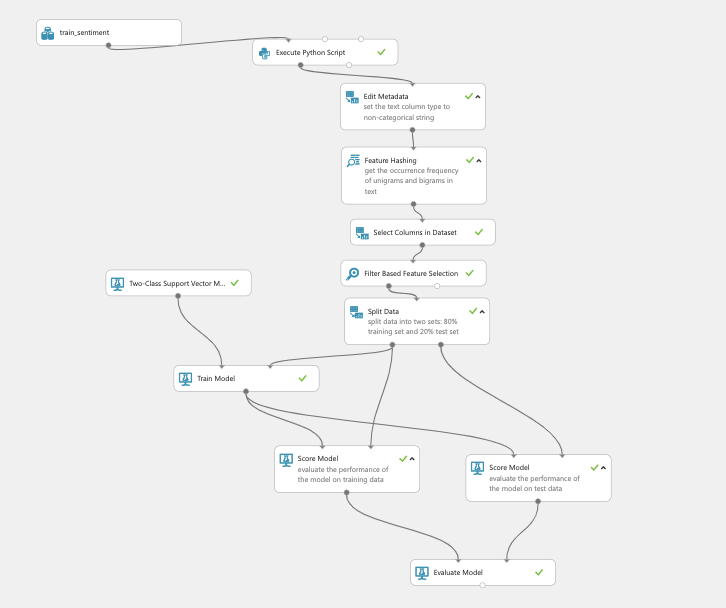

### ROC and OTHER METRCS FROM AZURE ML STUDIO
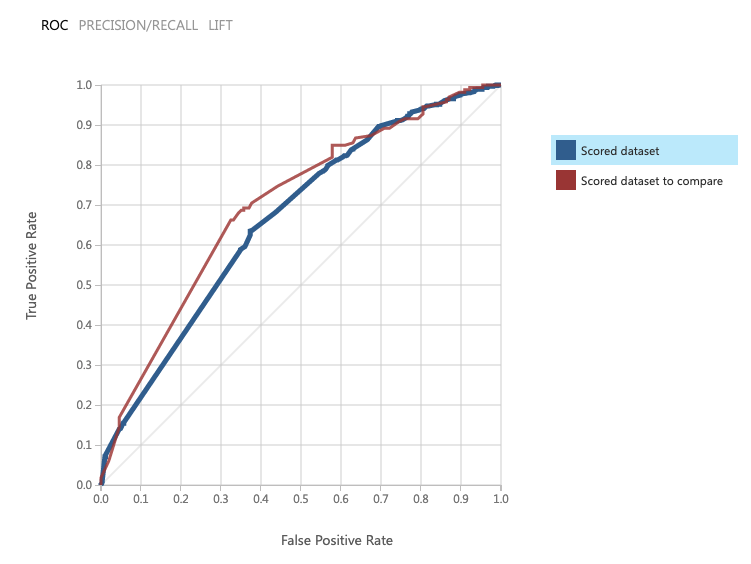

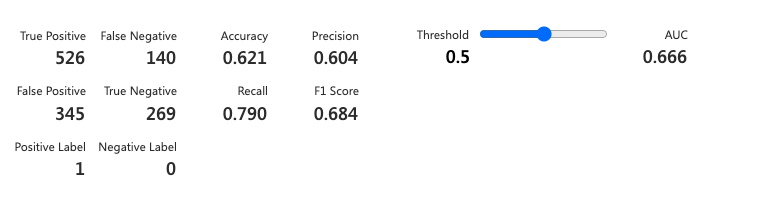



In [190]:
## BATCH TEST AFTER DEPLOYMENT

In [500]:
## urllib2.request?

# 3. BASE MODEL WITHOUT PRETRAINED EMBEDDING

Here we start the third part of the projet: Training and deploying Advanced models. To do so we thought of building a base model. A simple archintecture model without lemmatizing and stemming but the possibility to let model create its own embedding matrix.

**Model Own Embedding Creation** from a vacbaulary size of 10000 and max length of 50, we project our vocabulary (after tokenization and sequencing) in a dimension of 16 through a dense layer (a simple neural network).

A Sequential keras API adding layers will do the rest. We added a Bidirectional LSTM layer with 128 output unit and then Dropout, another Bidirectional LSTM, then a Dropout, a Flatten and a sigmoid Dense layer for the final output of our binary classification model.

## 3.1.1  BIDIRECTIONAL LSTM WITHOUT LEMMATIZING AND STEMMING



In [215]:
# some parameters
vocab_size = 10000
embedding_dim = 25
max_len = 50
trunc_type='post'
oov_tok = "<OOV>"

# instantiate the trokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

def prepareInputSplit(Xparsed, yp):
    
    X_train, X_val, y_train, y_val = train_test_split(Xparsed, yp,
                                                    test_size=0.20, 
                                                    stratify= yp,
                                                    random_state=42)
    return X_train, X_val, y_train, y_val
    
# param X_parsed, y
def prepareInputTweet(Xparsed, yp):
    
    X_train, X_val, y_train, y_val = train_test_split(Xparsed, yp,
                                                    test_size=0.20, 
                                                    stratify= yp,
                                                    random_state=42)
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq= tokenizer.texts_to_sequences(X_train)
    X_val_seq= tokenizer.texts_to_sequences(X_val)
    
    max_len = np.max([len(x) for x in X_train_seq ])
    
    X_train_seq_pad = pad_sequences(X_train_seq , maxlen=max_len, truncating=trunc_type)
    X_val_seq_pad = pad_sequences(X_val_seq , maxlen=max_len, truncating=trunc_type)
    
    return X_train_seq_pad, X_val_seq_pad, y_train, y_val, tokenizer


def prepareInputTweetScoring(Xparsed, yp, max_len, train_tokenizer):

    X_test_seq= train_tokenizer.texts_to_sequences(Xparsed)
    
    X_test_seq_pad = pad_sequences(X_test_seq , maxlen=max_len, truncating=trunc_type)
    
    return X_test_seq_pad , yp

#X_train_seq_pad, X_val_seq_pad, y_train, y_val = prepareInputTweet(X_parsed, y)

#print(max_len)
# model function
def model_own_embedding(X_train_seq_pad, X_val_seq_pad, y_train, y_val, num_epochs):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    num_epochs = num_epochs
    history = model.fit(X_train_seq_pad,
                        y_train,
                        epochs=num_epochs,
                        validation_data=(X_val_seq_pad, y_val))
    return model, history
    
import matplotlib.pyplot as plt
def plottingTrainValAccuracy(hist): 
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    
    
    
    plt.show()
    
def plottingTrainValAccuracy2(hist): 
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    
    
    
    plt.show()
    
    
#model_own_embedding(X_train_seq_pad, X_val_seq_pad, y_train, y_val, num_epochs=2)    

In [216]:
X_train_seq_pad, X_val_seq_pad, y_train, y_val, train_tokenizer = prepareInputTweet(X_train_ds, ytrain)

In [217]:
model1, history1= model_own_embedding(X_train_seq_pad, X_val_seq_pad, y_train, y_val, num_epochs=20)    

Epoch 1/20
40/40 [==============================] - 4s 30ms/step - loss: 0.6930 - accuracy: 0.5086 - val_loss: 0.6914 - val_accuracy: 0.5188
Epoch 2/20
40/40 [==============================] - 1s 18ms/step - loss: 0.6759 - accuracy: 0.5961 - val_loss: 0.6621 - val_accuracy: 0.6062
Epoch 3/20
40/40 [==============================] - 1s 19ms/step - loss: 0.4299 - accuracy: 0.8148 - val_loss: 0.6459 - val_accuracy: 0.6750
Epoch 4/20
40/40 [==============================] - 1s 17ms/step - loss: 0.1301 - accuracy: 0.9586 - val_loss: 0.7860 - val_accuracy: 0.6500
Epoch 5/20
40/40 [==============================] - 1s 15ms/step - loss: 0.0487 - accuracy: 0.9828 - val_loss: 1.2337 - val_accuracy: 0.6594
Epoch 6/20
40/40 [==============================] - 1s 15ms/step - loss: 0.0177 - accuracy: 0.9969 - val_loss: 1.7210 - val_accuracy: 0.6625
Epoch 7/20
40/40 [==============================] - 1s 15ms/step - loss: 0.0102 - accuracy: 0.9961 - val_loss: 1.3109 - val_accuracy: 0.6781
Epoch 8/20
40

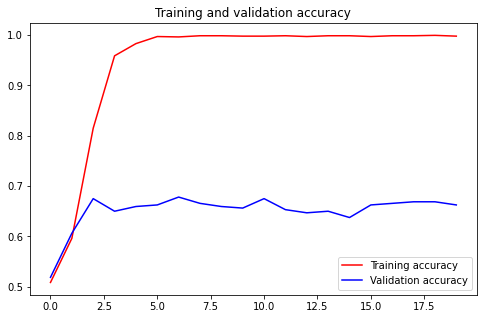

In [218]:
plottingTrainValAccuracy(history1)

## 3.1.2 TEST BIDIRECTIONAL LSTM WITHOUT LEMMATIZING AND STEMMING

In [219]:
# PREPARE THE RAW INPUT
# SCORE IT USING THE MODEL

In [220]:
def convertPredOneZero(modelToScore,raw_array):
    pred=modelToScore.predict(raw_array.reshape(1,max_len))
    
    if pred > 0.5 : 
        return 1
    else:    
        return 0
    
def scoreTweetModel(modelToScore,  test_ds, df_test):
    
    pred_score=[]
    test_ds_rows=test_ds

    for raw_array in test_ds_rows:
        pred_score.append(convertPredOneZero(modelToScore, raw_array))
    
    df_test['pred_score']=pred_score
    #print("The Accuracy with transformed neutral score in the data in the accuracy computation")
    return sum(np.where(df_test.target== df_test.pred_score, 1, 0))/df_test.shape[0]
    
    

In [221]:
#X_test_ds, X_test_lem_ds, X_test_stem_ds = cleanInput(df_test)
X_test_lem_ds, X_test_stem_ds = applyLemOrStemOnDF(df_test)

In [222]:
test_ds, label = prepareInputTweetScoring(X_test_ds, ytrain, max_len, train_tokenizer)

In [223]:
model1.evaluate(test_ds, label)[1]

50/50 [==============================] - 4s 10ms/step - loss: 4.5813 - accuracy: 0.5038


0.5037500262260437

In [224]:
score_test = scoreTweetModel(model1, test_ds, df_test)
print(score_test)
df_compare['BID_LSTM']= score_test

0.63375


# 4. BIDIRECTIONAL LSTM  GLOVE EMBEDDING

At thsi aprt we are going to use pretrained Embedding weight to build our embedding matrices.

The process of the embedding is as follows : 
- download the word embeding here the Glove, that we got from somewhere over the internet
- process it to get a dictionnary of word to vecteur map
- Before using the word emebdding dictionnary to get a vector representation of our words in the new dimension, we need to tokenize and hash our vocabulary (transform our text dataset to sequence of numbers) and keep word index dictionary that helps not only to revert to words from sequences when needed, but also to index words in the embedding dictionnary and for word vector representation.
   

In [225]:
from embedding_utils import *
from emo_utils import *

In [226]:

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Limit on the number of features to K features.
TOP_K = 20000

# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 50

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, tweets):
        # Vectorize training and validation texts.
        
        tweets = self.tokenizer.texts_to_sequences(tweets)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        tweets = sequence.pad_sequences(tweets, maxlen=self.max_length, truncating='post',padding='post')
        return tweets
    

In [227]:
# INSTANTIATE THE TOKENIZERS FROM LEM AND STEM DATASETS
tokenizer_lem = CustomTokenizer(train_texts = X_train_lem_ds)
tokenizer_stem = CustomTokenizer(train_texts = X_train_stem_ds)

In [228]:
# FIT TOKENIZER TO THE DATASET TO CREATE WORD INDEX FROM DATASET
tokenizer_lem.train_tokenize()
tokenizer_stem.train_tokenize()

In [229]:
# VECTORIZATION PROCESS
# WORDS ARE REPRESENTED IN VECTORS OF INT NUMBER AND THEN POST PADDED WITHN 50, POST TRNUCNATED
X_train_lem_tk = tokenizer_lem.vectorize_input(X_train_lem_ds)
X_train_stem_tk = tokenizer_stem.vectorize_input(X_train_stem_ds)

In [230]:
#tokenized_train.shape
X_train_lem_tk.shape

(1600, 50)

In [231]:
X_train_lem_tk[0]

array([1370,   13,   26,  100,  382,   65, 1371,   37, 1372,   43,  849,
       1373, 1374,  850,   60,  469,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [232]:
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant
import tqdm

EMBEDDING_VECTOR_LENGTH = 50 
def embedding_dic_FromFile(glove_file, word_index):
    #
    embedding_dict = {}
    with open(glove_file,'r') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    return embedding_dict


def construct_embedding_matrix(embedding_dict, word_index):
    
    num_words=len(word_index)+1
        #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))
    
    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
                vect=embedding_dict.get(word, [])
                if len(vect)>0:
                    embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
        
    return embedding_matrix

# TRAINING UTILS FUNCTIONS

def training_bid_lstm_embedding(vocab_word_index, embedding_matrix, X_train, X_val, y_train, y_val, n_epochs):

    model=Sequential()
    
    embedding=Embedding(len(vocab_word_index)+1, # number of unique tokens
                        EMBEDDING_VECTOR_LENGTH, #number of features
                        embeddings_initializer=Constant(embedding_matrix), # initialize 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=False)
    
    model.add(embedding)
    model.add(Dropout(0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.5))
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False ))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    optimzer = Adam(clipvalue=0.5) # clip value to avoid the gradient exploding
    
    model.compile(optimizer=optimzer, 
                  loss='binary_crossentropy', 
                  metrics=['acc',f1_m,precision_m, recall_m])
    
    # fit the model
    history = model.fit(X_train, y_train, 
                        batch_size=32, 
                        epochs=n_epochs, 
                        validation_data=(X_val, y_val), 
                        verbose=2)
    return history, model

# CUSTOM METRICS TO INCLUED IN TRAINING
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
               

In [233]:
# GOVE TEXT FILE RETRIEVAL AND PREPROCESSING

glove_file = "./data/glove.6B.50d.txt"

glove_embedding_dic_lem= embedding_dic_FromFile(glove_file, tokenizer_lem.tokenizer.word_index)
glove_embedding_dic_stem= embedding_dic_FromFile(glove_file, tokenizer_stem.tokenizer.word_index)

glove_embedding_mat_lem= construct_embedding_matrix(glove_embedding_dic_lem, 
                                                    tokenizer_lem.tokenizer.word_index)
glove_embedding_mat_stem= construct_embedding_matrix(glove_embedding_dic_stem, 
                                                     tokenizer_stem.tokenizer.word_index)

100%|██████████| 4156/4156 [00:00<00:00, 619369.22it/s]


## 4.1. GLOVE BIDIRECTIONAL LSTM WITH LEMMATIZING 

## 4.1.1 TRAINING GLOVE BIDIRECTIONAL LSTM WITH LEMMATIZING 

In [234]:
X_train, X_val, y_train, y_val = prepareInputSplit(X_train_lem_tk, ytrain)

vocab_word_index= tokenizer_lem.tokenizer.word_index
embedding_matrix= glove_embedding_mat_lem

history , model_glove1 = training_bid_lstm_embedding(vocab_word_index, embedding_matrix, 
                                                     X_train, X_val, 
                                                     y_train, y_val, n_epochs =20)


Epoch 1/20
40/40 - 2s - loss: 0.6931 - acc: 0.5055 - f1_m: 0.5863 - precision_m: 0.4498 - recall_m: 0.8592 - val_loss: 0.6919 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 2/20
40/40 - 1s - loss: 0.6892 - acc: 0.5750 - f1_m: 0.6520 - precision_m: 0.6103 - recall_m: 0.8117 - val_loss: 0.6391 - val_acc: 0.6719 - val_f1_m: 0.7358 - val_precision_m: 0.6372 - val_recall_m: 0.8809
Epoch 3/20
40/40 - 1s - loss: 0.6672 - acc: 0.6125 - f1_m: 0.6457 - precision_m: 0.6146 - recall_m: 0.7051 - val_loss: 0.6307 - val_acc: 0.6844 - val_f1_m: 0.6680 - val_precision_m: 0.7407 - val_recall_m: 0.6170
Epoch 4/20
40/40 - 1s - loss: 0.6593 - acc: 0.6195 - f1_m: 0.5805 - precision_m: 0.6790 - recall_m: 0.5487 - val_loss: 0.6519 - val_acc: 0.6625 - val_f1_m: 0.6460 - val_precision_m: 0.7036 - val_recall_m: 0.6046
Epoch 5/20
40/40 - 1s - loss: 0.6521 - acc: 0.6266 - f1_m: 0.5843 - precision_m: 0.6987 - recall_m: 0.5487 - val_loss: 0.6188 - val_acc: 0.6687 - val_f1

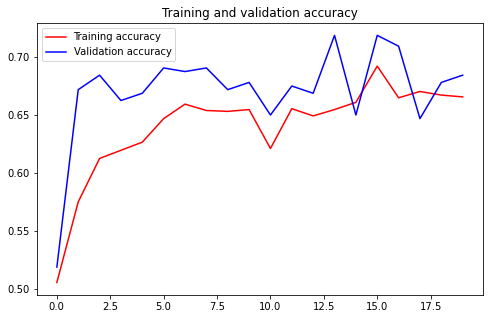

In [235]:
plottingTrainValAccuracy2(history)

## 4.1.1 TESTING GLOVE BIDIRECTIONAL LSTM WITH LEMMATIZING 

In [236]:
#X_test_ds, X_test_lem_ds, X_test_stem_ds = cleanInput(df_test)

test_ds, label = prepareInputTweetScoring(X_test_lem_ds, ytrain, max_len, tokenizer_lem.tokenizer)

print(model_glove1.evaluate(test_ds, label)[1])

50/50 [==============================] - 0s 4ms/step - loss: 0.7090 - acc: 0.4925 - f1_m: 0.5145 - precision_m: 0.5132 - recall_m: 0.5306
0.4925000071525574


In [237]:
score_test=scoreTweetModel(model_glove1, test_ds, df_test)
print(score_test)
df_compare['BID_LSTM_GLOVE_LEMMATIZING']= score_test

0.63625


## 4.2. GLOVE BIDIRECTIONAL LSTM  WITH STEMMING

## 4.2.1 TRAINING GLOVE BIDIRECTIONAL LSTM  WITH STEMMING

In [238]:
X_train, X_val, y_train, y_val = prepareInputSplit(X_train_stem_tk, ytrain)

vocab_word_index= tokenizer_stem.tokenizer.word_index
embedding_matrix= glove_embedding_mat_stem

history , model_glove2 = training_bid_lstm_embedding(vocab_word_index, embedding_matrix, 
                                                     X_train, X_val, 
                                                     y_train, y_val, n_epochs =20)


Epoch 1/20
40/40 - 2s - loss: 0.6931 - acc: 0.5078 - f1_m: 0.5666 - precision_m: 0.4491 - recall_m: 0.8244 - val_loss: 0.6914 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 2/20
40/40 - 1s - loss: 0.6883 - acc: 0.5484 - f1_m: 0.6374 - precision_m: 0.5732 - recall_m: 0.8221 - val_loss: 0.6603 - val_acc: 0.6281 - val_f1_m: 0.5934 - val_precision_m: 0.7005 - val_recall_m: 0.5236
Epoch 3/20
40/40 - 1s - loss: 0.6501 - acc: 0.6281 - f1_m: 0.6506 - precision_m: 0.6305 - recall_m: 0.6924 - val_loss: 0.6299 - val_acc: 0.6594 - val_f1_m: 0.6489 - val_precision_m: 0.7248 - val_recall_m: 0.5949
Epoch 4/20
40/40 - 1s - loss: 0.6560 - acc: 0.6313 - f1_m: 0.6407 - precision_m: 0.6495 - recall_m: 0.6535 - val_loss: 0.6408 - val_acc: 0.6500 - val_f1_m: 0.7187 - val_precision_m: 0.6179 - val_recall_m: 0.8669
Epoch 5/20
40/40 - 1s - loss: 0.6451 - acc: 0.6398 - f1_m: 0.6549 - precision_m: 0.6566 - recall_m: 0.6834 - val_loss: 0.6291 - val_acc: 0.6531 - val_f1

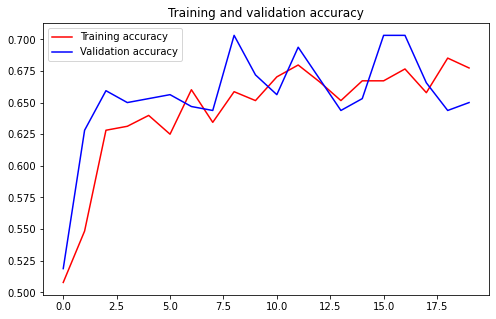

In [239]:
plottingTrainValAccuracy2(history)

## 4.2.2 TESTING GLOVE BIDIRECTIONAL LSTM  WITH STEMMING

In [240]:
#X_test_ds, X_test_lem_ds, X_test_stem_ds = cleanInput(df_test)

test_ds, label = prepareInputTweetScoring(X_test_ds, ytrain, max_len, tokenizer_stem.tokenizer)

model_glove2.evaluate(test_ds, label)[2]

50/50 [==============================] - 0s 4ms/step - loss: 0.7162 - acc: 0.4906 - f1_m: 0.5650 - precision_m: 0.5104 - recall_m: 0.6542


0.5649833083152771

In [241]:
score_test=scoreTweetModel(model_glove2, test_ds, df_test)
print(score_test)
df_compare['BID_LSTM_GLOVE_STEMMING']= score_test

0.516875


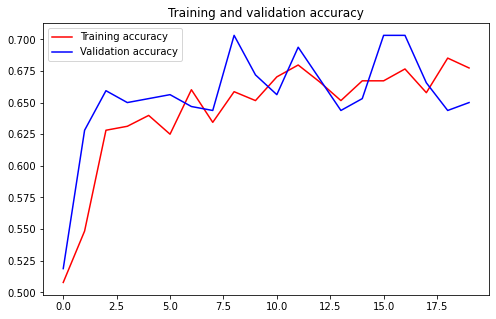

In [242]:
plottingTrainValAccuracy2(history)

# 5. MODEL BIDIRECTIONAL LSTM  WITH WORD2VEC EMBEDDING

In [243]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [244]:
# create a dictionnay from it
# easier to manipulate 
word2vec_dic={}

for i in word2vec.key_to_index:
    word2vec_dic[i]=word2vec.get_vector(i)

In [245]:
#word2vec_dic

In [246]:
def embedding_dic_FromFile(glove_file, word_index):
    #
    embedding_dict = {}
    with open(glove_file,'r') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    return embedding_dict

In [247]:
def embedding_dic_FromDict(emb_dict, word_index):
    #
    embedding_dict = {}
    for word, array in emb_dict.items():
        if word in word_index.keys():
                # get the vector
                embedding_dict[word] = array
    return embedding_dict

In [248]:
word2vec_embedding_dic_lem= embedding_dic_FromDict(word2vec_dic, tokenizer_lem.tokenizer.word_index)
word2vec_embedding_dic_stem= embedding_dic_FromDict(word2vec_dic, tokenizer_stem.tokenizer.word_index)

In [249]:
len(word2vec_embedding_dic_lem)

3431

In [250]:
len(glove_embedding_dic_lem)

3571

In [251]:
word2vec_embedding_mat_lem= construct_embedding_matrix(word2vec_embedding_dic_lem, 
                                                    tokenizer_lem.tokenizer.word_index)
word2vec_embedding_mat_stem= construct_embedding_matrix(word2vec_embedding_dic_stem, 
                                                     tokenizer_stem.tokenizer.word_index)

100%|██████████| 4156/4156 [00:00<00:00, 196761.87it/s]


## 5.1.1 TRAINING WORD2VEC BIDIRECTIONAL LSTM  WITH LEMMATIZING 

In [252]:
#model_bid_lstm_w2v=bid_lstm_embedding((max_len, ), word2vec_dic, w2v_word_to_index)

In [253]:
X_train, X_val, y_train, y_val = prepareInputSplit(X_train_lem_tk, ytrain)

vocab_word_index= tokenizer_lem.tokenizer.word_index
embedding_matrix= word2vec_embedding_mat_lem

history , model_w2v1 = training_bid_lstm_embedding(vocab_word_index, embedding_matrix, 
                                                     X_train, X_val, 
                                                     y_train, y_val, n_epochs =20)


Epoch 1/20
40/40 - 2s - loss: 0.6931 - acc: 0.5039 - f1_m: 0.5777 - precision_m: 0.4491 - recall_m: 0.8424 - val_loss: 0.6924 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 2/20
40/40 - 1s - loss: 0.6938 - acc: 0.5219 - f1_m: 0.6563 - precision_m: 0.5293 - recall_m: 0.9394 - val_loss: 0.6794 - val_acc: 0.5750 - val_f1_m: 0.5373 - val_precision_m: 0.6266 - val_recall_m: 0.4894
Epoch 3/20
40/40 - 1s - loss: 0.6717 - acc: 0.5969 - f1_m: 0.6173 - precision_m: 0.6240 - recall_m: 0.6387 - val_loss: 0.6705 - val_acc: 0.5906 - val_f1_m: 0.6569 - val_precision_m: 0.5772 - val_recall_m: 0.7716
Epoch 4/20
40/40 - 1s - loss: 0.6602 - acc: 0.6281 - f1_m: 0.6336 - precision_m: 0.6545 - recall_m: 0.6503 - val_loss: 0.6696 - val_acc: 0.6156 - val_f1_m: 0.6419 - val_precision_m: 0.6127 - val_recall_m: 0.6782
Epoch 5/20
40/40 - 1s - loss: 0.6606 - acc: 0.6062 - f1_m: 0.5517 - precision_m: 0.6676 - recall_m: 0.4929 - val_loss: 0.6891 - val_acc: 0.5719 - val_f1

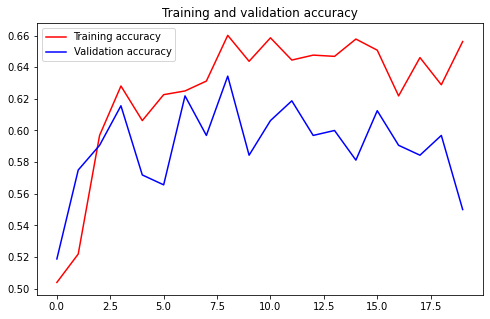

In [254]:
plottingTrainValAccuracy2(history)


## 5.1.2 TESTING WORD2VEC BIDIRECTIONAL LSTM  WITH LEMMATIZING 

In [255]:
#X_test_ds, X_test_lem_ds, X_test_stem_ds = cleanInput(df_test)

test_ds, label = prepareInputTweetScoring(X_test_ds, ytrain, max_len, tokenizer_lem.tokenizer)

model_w2v1.evaluate(test_ds, label)[1]

50/50 [==============================] - 0s 4ms/step - loss: 0.7015 - acc: 0.5138 - f1_m: 0.6682 - precision_m: 0.5179 - recall_m: 0.9641


0.5137500166893005

In [256]:
score_test=scoreTweetModel(model_w2v1, test_ds, df_test)
print(score_test)
df_compare['BID_LSTM_W2V_LEMMATIZING']= score_test

0.4875


## 5.2 WORD2VEC BIDIRECTIONAL LSTM   WITH STEMMING

## 5.2.1 TRAINING WORD2VEC BIDIRECTIONAL LSTM   WITH STEMMING

In [257]:
X_train, X_val, y_train, y_val = prepareInputSplit(X_train_stem_tk, ytrain)

vocab_word_index= tokenizer_stem.tokenizer.word_index
embedding_matrix= word2vec_embedding_mat_stem

history , model_w2v2 = training_bid_lstm_embedding(vocab_word_index, embedding_matrix, 
                                                     X_train, X_val, 
                                                     y_train, y_val, n_epochs =20)

Epoch 1/20
40/40 - 2s - loss: 0.6931 - acc: 0.5039 - f1_m: 0.5845 - precision_m: 0.4481 - recall_m: 0.8558 - val_loss: 0.6924 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 2/20
40/40 - 1s - loss: 0.6927 - acc: 0.5203 - f1_m: 0.6787 - precision_m: 0.5203 - recall_m: 1.0000 - val_loss: 0.6924 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 3/20
40/40 - 1s - loss: 0.6931 - acc: 0.5227 - f1_m: 0.6412 - precision_m: 0.5354 - recall_m: 0.8875 - val_loss: 0.6924 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 4/20
40/40 - 1s - loss: 0.6924 - acc: 0.5203 - f1_m: 0.6814 - precision_m: 0.5203 - recall_m: 1.0000 - val_loss: 0.6920 - val_acc: 0.5188 - val_f1_m: 0.6812 - val_precision_m: 0.5188 - val_recall_m: 1.0000
Epoch 5/20
40/40 - 1s - loss: 0.6884 - acc: 0.5555 - f1_m: 0.6020 - precision_m: 0.5813 - recall_m: 0.7007 - val_loss: 0.6828 - val_acc: 0.5688 - val_f1

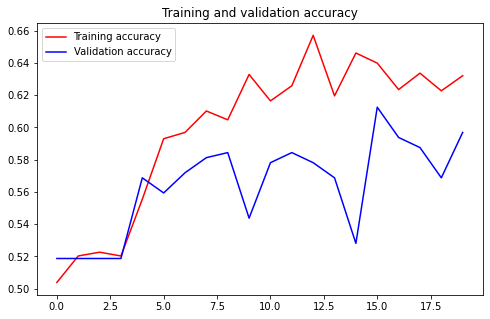

In [258]:
plottingTrainValAccuracy2(history)

## 5.2 TESTING WORD2VEC BIDIRECTIONAL LSTM   WITH STEMMING

In [259]:
#X_test_ds, X_test_lem_ds, X_test_stem_ds = cleanInput(df_test)

test_ds, label = prepareInputTweetScoring(X_test_ds, ytrain, max_len, tokenizer_stem.tokenizer)

model_w2v2.evaluate(test_ds, label)

50/50 [==============================] - 0s 4ms/step - loss: 0.7281 - acc: 0.5200 - f1_m: 0.6790 - precision_m: 0.5200 - recall_m: 1.0000


[0.7281244397163391,
 0.5199999809265137,
 0.6790323853492737,
 0.5199999809265137,
 1.0]

In [260]:
score_test = scoreTweetModel(model_w2v2, test_ds, df_test)
print(score_test)
df_compare['BID_LSTM_W2V_STEMMING']= score_test

0.47625


In [261]:
df_compare

{'TEXT_ANALYTICS_NEUTRAL_FILTERED': 0.6817063166529943,
 'TEXT_ANALYTICS_NEUTRAL_TRANSFORMED': 0.729375,
 'BID_LSTM': 0.63375,
 'BID_LSTM_GLOVE_LEMMATIZING': 0.63625,
 'BID_LSTM_GLOVE_STEMMING': 0.516875,
 'BID_LSTM_W2V_LEMMATIZING': 0.4875,
 'BID_LSTM_W2V_STEMMING': 0.47625}

# 6. USING A PRETAINED BERT MODEL  

In [125]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [126]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [266]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
    
# prep data
def prepDataBert(X_train, X_val, y_train, y_val):
    
    X_train_tokenized = bert_tokenizer(X_train, padding=True, truncation=True, max_length=max_len)
    
    X_val_tokenized = bert_tokenizer(X_val, padding=True, truncation=True, max_length=max_len)
    
    train_dataset = Dataset(X_train_tokenized, y_train)
    
    val_dataset = Dataset(X_val_tokenized, y_val)
    
    return train_dataset, val_dataset

# prep data for testing
def prepDataBertTesting(X_test, y_test, bert_tokenizer, max_len):
    
    X_test_tokenized = bert_tokenizer(X_test, padding=True, truncation=True, max_length=max_len)
    
    y_test=list(y_test)
    
    test_dataset = Dataset(X_test_tokenized, y_test)

    return test_dataset


# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# define arg and train
def bertDefTrain(train_dataset, val_dataset):
    
    # Define Trainer
    args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=15,
        seed=0,
        load_best_model_at_end=True )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
    
    trainer.train()
    
    return trainer

In [211]:
#bertDefTrain(train_dataset, val_dataset)

In [267]:
#model
print(model_name)
print(bert_tokenizer)

bert-base-uncased
PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


## 6.1 BERT WITH LEMMATIZING 


## 6.1.1 TRAINING BERT WITH LEMMATIZING 

In [268]:
# DATA PREP
X_train, X_val, y_train, y_val = prepareInputSplit(X_train_lem_ds , ytrain)

X_train=list(X_train)
y_train=list(y_train)

X_val=list(X_val)
y_val=list(y_val)

In [130]:
train_dataset, val_dataset = prepDataBert(X_train, X_val, y_train, y_val)

modelBERT = bertDefTrain(train_dataset, val_dataset)

***** Running training *****
  Num examples = 1280
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.481700,1.446889,0.687500,0.673684,0.771084,0.719101
1000,0.056300,2.469601,0.671875,0.701987,0.638554,0.668770
1500,0.018900,2.626311,0.675000,0.682353,0.698795,0.690476
2000,0.008100,2.708514,0.696875,0.714286,0.692771,0.703364


***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.4817
Attempted to log scalar metric learning_rate:
3.958333333333333e-05
Attempted to log scalar metric epoch:
3.12
Attempted to log scalar metric eval_loss:
1.4468889236450195
Attempted to log scalar metric eval_accuracy:
0.6875
Attempted to log scalar metric eval_precision:
0.6736842105263158
Attempted to log scalar metric eval_recall:
0.7710843373493976
Attempted to log scalar metric eval_f1:
0.7191011235955056
Attempted to log scalar metric eval_runtime:
17.6556
Attempted to log scalar metric eval_samples_per_second:
18.125
Attempted to log scalar metric eval_steps_per_second:
2.266
Attempted to log scalar metric epoch:
3.12


Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.0563
Attempted to log scalar metric learning_rate:
2.916666666666667e-05
Attempted to log scalar metric epoch:
6.25
Attempted to log scalar metric eval_loss:
2.4696011543273926
Attempted to log scalar metric eval_accuracy:
0.671875
Attempted to log scalar metric eval_precision:
0.7019867549668874
Attempted to log scalar metric eval_recall:
0.6385542168674698
Attempted to log scalar metric eval_f1:
0.668769716088328
Attempted to log scalar metric eval_runtime:
17.5449
Attempted to log scalar metric eval_samples_per_second:
18.239
Attempted to log scalar metric eval_steps_per_second:
2.28
Attempted to log scalar metric epoch:
6.25


Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.0189
Attempted to log scalar metric learning_rate:
1.8750000000000002e-05
Attempted to log scalar metric epoch:
9.38
Attempted to log scalar metric eval_loss:
2.6263108253479004
Attempted to log scalar metric eval_accuracy:
0.675
Attempted to log scalar metric eval_precision:
0.6823529411764706
Attempted to log scalar metric eval_recall:
0.6987951807228916
Attempted to log scalar metric eval_f1:
0.6904761904761905
Attempted to log scalar metric eval_runtime:
17.6963
Attempted to log scalar metric eval_samples_per_second:
18.083
Attempted to log scalar metric eval_steps_per_second:
2.26
Attempted to log scalar metric epoch:
9.38


Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.0081
Attempted to log scalar metric learning_rate:
8.333333333333334e-06
Attempted to log scalar metric epoch:
12.5
Attempted to log scalar metric eval_loss:
2.7085137367248535
Attempted to log scalar metric eval_accuracy:
0.696875
Attempted to log scalar metric eval_precision:
0.7142857142857143
Attempted to log scalar metric eval_recall:
0.6927710843373494
Attempted to log scalar metric eval_f1:
0.7033639143730888
Attempted to log scalar metric eval_runtime:
17.5479
Attempted to log scalar metric eval_samples_per_second:
18.236
Attempted to log scalar metric eval_steps_per_second:
2.279
Attempted to log scalar metric epoch:
12.5


Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-500 (score: 1.4468889236450195).


Attempted to log scalar metric train_runtime:
4497.0648
Attempted to log scalar metric train_samples_per_second:
4.269
Attempted to log scalar metric train_steps_per_second:
0.534
Attempted to log scalar metric total_flos:
271333275840000.0
Attempted to log scalar metric train_loss:
0.14124004197120665
Attempted to log scalar metric epoch:
12.5


In [269]:
#trainer.evaluate(train_dataset)

## 6.1.2 TESTING BERT WITH LEMMATIZING 


In [270]:
# PREPARE INPUT FOR TESTING
test_bert_ds = prepDataBertTesting(X_test_lem_ds, ytest, bert_tokenizer, max_len)
#trainer.evaluate(test_bert_ds)
modelBERT.evaluate(test_bert_ds)

***** Running Evaluation *****
  Num examples = 1600
  Batch size = 8


Attempted to log scalar metric eval_loss:
1.246070146560669
Attempted to log scalar metric eval_accuracy:
0.7325
Attempted to log scalar metric eval_precision:
0.6843267108167771
Attempted to log scalar metric eval_recall:
0.8136482939632546
Attempted to log scalar metric eval_f1:
0.7434052757793765
Attempted to log scalar metric eval_runtime:
116.7164
Attempted to log scalar metric eval_samples_per_second:
13.708
Attempted to log scalar metric eval_steps_per_second:
1.714
Attempted to log scalar metric epoch:
12.5


{'eval_loss': 1.246070146560669,
 'eval_accuracy': 0.7325,
 'eval_precision': 0.6843267108167771,
 'eval_recall': 0.8136482939632546,
 'eval_f1': 0.7434052757793765,
 'eval_runtime': 116.7164,
 'eval_samples_per_second': 13.708,
 'eval_steps_per_second': 1.714,
 'epoch': 12.5}

In [264]:
print("Accuracy for BERT Model with LEMMATIZING")
#pred=trainer.predict(test_bert_ds)
pred=modelBERT.predict(test_bert_ds)
print(pred.metrics['test_accuracy'])
df_compare['BERT_LEMMATIZING']= pred.metrics['test_accuracy']

Accuracy for BERT Model with LEMMATIZING


NameError: name 'test_bert_ds' is not defined


## 6.2 BERT  WITH STEMMING 


## 6.2.1 TRAINING BERT  WITH STEMMING 

In [538]:
# DATA PREP
X_train, X_val, y_train, y_val = prepareInputSplit(X_train_stem_tk , ytrain)

X_train=list(X_train)
y_train=list(y_train)

X_val=list(X_val)
y_val=list(y_val)

train_dataset, val_dataset = prepDataBert(X_train, X_val, y_train, y_val)

bertDefTrain(train_dataset, val_dataset)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1280
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.089600,2.465918,0.675000,0.666667,0.746988,0.704545
1000,0.036400,2.492934,0.684375,0.696970,0.692771,0.694864
1500,0.011400,2.914154,0.687500,0.679348,0.753012,0.714286
2000,0.001000,3.293457,0.678125,0.653659,0.807229,0.722372


***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.0896
Attempted to log scalar metric learning_rate:
3.958333333333333e-05
Attempted to log scalar metric epoch:
3.12
Attempted to log scalar metric eval_loss:
2.4659175872802734
Attempted to log scalar metric eval_accuracy:
0.675
Attempted to log scalar metric eval_precision:
0.6666666666666666
Attempted to log scalar metric eval_recall:
0.7469879518072289
Attempted to log scalar metric eval_f1:
0.7045454545454546
Attempted to log scalar metric eval_runtime:
12.1394
Attempted to log scalar metric eval_samples_per_second:
26.36
Attempted to log scalar metric eval_steps_per_second:
3.295
Attempted to log scalar metric epoch:
3.12


Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.0364
Attempted to log scalar metric learning_rate:
2.916666666666667e-05
Attempted to log scalar metric epoch:
6.25
Attempted to log scalar metric eval_loss:
2.492933750152588
Attempted to log scalar metric eval_accuracy:
0.684375
Attempted to log scalar metric eval_precision:
0.696969696969697
Attempted to log scalar metric eval_recall:
0.6927710843373494
Attempted to log scalar metric eval_f1:
0.6948640483383686
Attempted to log scalar metric eval_runtime:
12.1378
Attempted to log scalar metric eval_samples_per_second:
26.364
Attempted to log scalar metric eval_steps_per_second:
3.295
Attempted to log scalar metric epoch:
6.25


Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.0114
Attempted to log scalar metric learning_rate:
1.8750000000000002e-05
Attempted to log scalar metric epoch:
9.38
Attempted to log scalar metric eval_loss:
2.914153575897217
Attempted to log scalar metric eval_accuracy:
0.6875
Attempted to log scalar metric eval_precision:
0.6793478260869565
Attempted to log scalar metric eval_recall:
0.7530120481927711
Attempted to log scalar metric eval_f1:
0.7142857142857143
Attempted to log scalar metric eval_runtime:
12.1318
Attempted to log scalar metric eval_samples_per_second:
26.377
Attempted to log scalar metric eval_steps_per_second:
3.297
Attempted to log scalar metric epoch:
9.38


Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 320
  Batch size = 8


Attempted to log scalar metric loss:
0.001
Attempted to log scalar metric learning_rate:
8.333333333333334e-06
Attempted to log scalar metric epoch:
12.5
Attempted to log scalar metric eval_loss:
3.29345703125
Attempted to log scalar metric eval_accuracy:
0.678125
Attempted to log scalar metric eval_precision:
0.6536585365853659
Attempted to log scalar metric eval_recall:
0.8072289156626506
Attempted to log scalar metric eval_f1:
0.7223719676549866
Attempted to log scalar metric eval_runtime:
12.1545
Attempted to log scalar metric eval_samples_per_second:
26.328
Attempted to log scalar metric eval_steps_per_second:
3.291
Attempted to log scalar metric epoch:
12.5


Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-500 (score: 2.4659175872802734).


Attempted to log scalar metric train_runtime:
3583.717
Attempted to log scalar metric train_samples_per_second:
5.358
Attempted to log scalar metric train_steps_per_second:
0.67
Attempted to log scalar metric total_flos:
189111071040000.0
Attempted to log scalar metric train_loss:
0.03459927755594253
Attempted to log scalar metric epoch:
12.5



## 6.2.2 TESTING BERT  WITH STEMMING 

In [539]:
# PREPARE INPUT FOR TESTING
test_bert_ds2 = prepDataBertTesting(X_test_stem_ds, ytest, bert_tokenizer, max_len)
#trainer.evaluate(test_bert_ds)
modelBERT.evaluate(test_bert_ds2)

***** Running Evaluation *****
  Num examples = 1600
  Batch size = 8


Attempted to log scalar metric eval_loss:
3.9922521114349365
Attempted to log scalar metric eval_accuracy:
0.49875
Attempted to log scalar metric eval_precision:
0.5163755458515283
Attempted to log scalar metric eval_recall:
0.5685096153846154
Attempted to log scalar metric eval_f1:
0.5411899313501144
Attempted to log scalar metric eval_runtime:
61.1248
Attempted to log scalar metric eval_samples_per_second:
26.176
Attempted to log scalar metric eval_steps_per_second:
3.272
Attempted to log scalar metric epoch:
12.5


{'eval_loss': 3.9922521114349365,
 'eval_accuracy': 0.49875,
 'eval_precision': 0.5163755458515283,
 'eval_recall': 0.5685096153846154,
 'eval_f1': 0.5411899313501144,
 'eval_runtime': 61.1248,
 'eval_samples_per_second': 26.176,
 'eval_steps_per_second': 3.272,
 'epoch': 12.5}

In [540]:
print("Accuracy for BERT Model with STEMMING")
#pred=trainer.predict(test_bert_ds)
pred=modelBERT.predict(test_bert_ds2)
print(pred.metrics['test_accuracy'])

df_compare['BERT_STEMMING']= pred.metrics['test_accuracy']

***** Running Prediction *****
  Num examples = 1600
  Batch size = 8


Accuracy for BERT Model with STEMMING
0.49875


In [263]:
#df_compare['BERT_STEMMING']= pred.metrics['test_accuracy']

# 7. COMPARE ADVANCE MODELS

In [136]:
# See How all those model perform on the test set???
df_compare

{'BID_LSTM': 0.506875,
 'BID_LSTM_GLOVE_LEMMATIZING': 0.465625,
 'BID_LSTM_GLOVE_STEMMING': 0.48125,
 'BID_LSTM_W2V_LEMMATIZING': 0.475,
 'BID_LSTM_W2V_STEMMING': 0.47625}

In [146]:
pd.DataFrame.from_dict(df_compare, orient= 'index', columns=['MPODEL_ACCURACY'])

,MPODEL_ACCURACY
BID_LSTM,0.506875
BID_LSTM_GLOVE_LEMMATIZING,0.465625
BID_LSTM_GLOVE_STEMMING,0.481250
BID_LSTM_W2V_LEMMATIZING,0.475000
BID_LSTM_W2V_STEMMING,0.476250


In [564]:
pd.DataFrame.from_dict(df_compare, orient= 'index', columns=['MPODEL_ACCURACY'])

,MPODEL_ACCURACY
TEXT_ANALYTICS_NEUTRAL_FILTERED,0.681706
TEXT_ANALYTICS_NEUTRAL_TRANSFORMED,0.729375
BID_LSTM,0.652500
BERT_LEMMATIZING,0.498125
BERT_STEMMING,0.498750
BID_LSTM_GLOVE_LEMMATIZING,0.476250
BID_LSTM_GLOVE_STEMMING,0.476250
BID_LSTM_W2V_LEMMATIZING,0.476250
BID_LSTM_W2V_STEMMING,0.476250


# 8. ADVANCED MODEL OR TRAINING THE BEST ON AZURE 

In [218]:
# Choose the WORD2VEC MODEL

In [ ]:

# Load the model after the embedding part
# And do some some hyper parameter test

In [ ]:
# X_train_word2vec_lem
# pandas and then to csv

# 8.1 UPLOAD DATA FROM LOCAL FILE

In [264]:
from azureml.core import Dataset

In [265]:
# UPLOAD DATA FROM LOCAL FILE

local_path_and_file='./data/train_sentiment1600.csv'
target_path = 'train-dataset/tabular/'

# instantiate the datastore
datastore = ws.get_default_datastore()
#upload files
datastore.upload_files(files = [local_path_and_file],
                       target_path = target_path,
                       overwrite = True,
                       show_progress = True)

# test by reading it dataset
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 
                                                        'train-dataset/tabular/train_sentiment1600.csv')])

dataset.take(3).to_pandas_dataframe()

Uploading an estimated of 1 files
Uploading ./data/train_sentiment1600.csv
Uploaded ./data/train_sentiment1600.csv, 1 files out of an estimated total of 1
Uploaded 1 files


,Column1,target,text
0,1443976,1,@snarkandboobs LOL at your last tweet. BTW-our...
1,735738,0,Kasabian tomorrow....I can't be excited until ...
2,1151914,1,Gonna hit the hay soon!!nighty night all


In [ ]:
# MODEL TO TRAIN IN PY

In [334]:
%%writefile tweet_train.py

import pandas as pd 
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import matplotlib.pyplot as plt
from keras.models import model_from_json
from keras.callbacks import Callback
from azureml.core import Dataset, Run


run = Run.get_context()
# get input dataset by name
dataset = run.input_datasets['x_train_word2vec'] # to modify with new data
    
df= dataset.to_pandas_dataframe()[['target', 'text']]

X= df.text.values
y= df.target.values

X_train, X_val, X_test = X[:1280], X[1280:1440], X[1440: ]
y_train, y_val, y_test = y[:1280], y[1280:1440], y[1440: ]

#X_train, X_val, X_test, y_train, y_val, y_test  = split_train_val_test(X, y, test_size=0.20, val_split=True)
#param
training_set_size = X_train.shape[0]
n_epochs = 5
batch_size = 32
#learning_rate = args.learning_rate

####################


# some parameters
vocab_size = 10000
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

# instantiate the trokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)


X_train_seq= tokenizer.texts_to_sequences(X_train)
X_test_seq= tokenizer.texts_to_sequences(X_test)
X_val_seq= tokenizer.texts_to_sequences(X_val)

max_len = np.max([len(x) for x in X_train_seq ])
print(max_len)

#max_len = max_len
X_train_seq_pad = pad_sequences(X_train_seq , maxlen=max_len, truncating=trunc_type)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=max_len, truncating=trunc_type)
X_val_seq_pad = pad_sequences(X_val_seq, maxlen=max_len, truncating=trunc_type)

# here my max length for every sequence in then sample


# create a function instead
#### MODEL
model = tf.keras.Sequential([
    
    # training en embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False )),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

#history = model_own_embedding.fit(X_train_seq_pad,
 #                   y_train,
 #                   epochs=num_epochs)


######## END MODEL


# start an Azure ML run
run = Run.get_context()


class LogRunMetrics(Callback):
    # callback at the end of every epoch
    def on_epoch_end(self, epoch, log):
        # log a value repeated which creates a list
        run.log('Loss', log['val_loss'])
        run.log('Accuracy', log['val_accuracy'])

print("#START TRAINING")
history = model.fit(X_train_seq_pad, y_train,
                                  epochs=n_epochs,
                                  validation_data=(X_val_seq_pad, y_val),
                                  callbacks=[LogRunMetrics()])

print("#START EVALUATING")
score = model.evaluate(X_test_seq_pad, y_test, verbose=0)

# log a single value
run.log("Final test loss", score[0])
print('Test loss:', score[0])

run.log('Final test accuracy', score[1])
##print('Test accuracy:', score[1])

plt.figure(figsize=(6, 3))
plt.title('Sample TWEET data training with ({} epochs)'.format(n_epochs), fontsize=14)
plt.plot(history.history['val_accuracy'], 'b-', label='Accuracy', lw=4, alpha=0.5)
plt.plot(history.history['val_loss'], 'r--', label='Loss', lw=4, alpha=0.5)
plt.legend(fontsize=12)
plt.grid(True)

# log an image
run.log_image('Accuracy vs Loss', plot=plt)

# create a ./outputs/model folder in the compute target
# files saved in the "./outputs" folder are automatically uploaded into run history
os.makedirs('./outputs/model', exist_ok=True)

# serialize NN architecture to JSON
model_json = model.to_json()
# save model JSON
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)
# save model weights
model.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

Overwriting tweet_train.py


In [ ]:
# CREATE CONFIGURATION

In [269]:
#script_folder

In [270]:
%%writefile conda_dependencies.yml

channels:
- conda-forge
dependencies:
 - python=3.8
 - pip=21.0.1
 - pip:
    - h5py<=2.10.0
    - azureml-defaults
    - azureml-dataprep[pandas]
    - tensorflow
    - keras<=2.3.1
    - matplotlib

Overwriting conda_dependencies.yml


In [271]:
from azureml.core import Environment

keras_env = Environment.from_conda_specification(name = 'keras-2.3.1', file_path = './conda_dependencies.yml')

# Specify a GPU base image
keras_env.docker.enabled = True
keras_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [ ]:
# CREATE COMPUTE

In [277]:
import os
from azureml.core import Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# CREATE AN EXPERIMENT
# create a script folder
script_folder = './tweetsentiment'
os.makedirs(script_folder, exist_ok=True)


# instantiate the experiment, the entry point for the Azure ML
exp = Experiment(workspace=ws, name='aigain_tweetsentimentexp')

# CREATE COMPUTE, A CLUSTER
# choose a name for your cluster
cluster_name = "tweeter-clus"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)
    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())


Found existing compute target
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 1, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-11-29T19:18:20.556000+00:00', 'errors': None, 'creationTime': '2021-11-29T18:47:21.205475+00:00', 'modifiedTime': '2021-11-29T18:48:17.307523+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


In [333]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./tweet_train.py', script_folder)

'./tweetsentiment/tweet_train.py'

In [278]:
# RUN
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory=script_folder,
                      script='tweet_train.py',
                      arguments=[dataset.as_named_input('x_train_word2vec')], # note the requirement
                      compute_target=compute_target,
                      environment=keras_env)


run = exp.submit(src)
print(run.wait_for_completion(show_output=True))

RunId: aigain_tweetsentimentexp_1638214049_ddb42779
Web View: https://ml.azure.com/runs/aigain_tweetsentimentexp_1638214049_ddb42779?wsid=/subscriptions/b7ff1da8-65bd-4db1-b5db-e88f05415e38/resourcegroups/kba-grp/workspaces/openclassroomws&tid=861804f8-2a75-405f-8138-f951a8a0fcde

Execution Summary
RunId: aigain_tweetsentimentexp_1638214049_ddb42779
Web View: https://ml.azure.com/runs/aigain_tweetsentimentexp_1638214049_ddb42779?wsid=/subscriptions/b7ff1da8-65bd-4db1-b5db-e88f05415e38/resourcegroups/kba-grp/workspaces/openclassroomws&tid=861804f8-2a75-405f-8138-f951a8a0fcde

Warnings:
This run might be using a new job runtime with improved performance and error reporting. The logs from your script are in user_logs/std_log.txt. Please let us know if you run into any issues, and if you would like to opt-out, please add the environment variable AZUREML_COMPUTE_USE_COMMON_RUNTIME to the environment variables section of the job and set its value to the string "false"


{'runId': 'aigain_twe

In [ ]:
# DEPLOYMENT

In [ ]:
## CREATE SCORE FILE

In [279]:
%%writefile score.py
import os
import json
import numpy as np
import pandas as pd

from azureml.core.model import Model
#from keras.models import model_from_json
from tensorflow.keras.models import model_from_json


def init():
    global model
    model_root = Model.get_model_path('tweet')
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print("The model from json : ", model)
 
    
def run(raw_data):
    data= np.array(json.loads(raw_data)['data'])
    
    y_hat=model.predict(data)
    return json.dumps(y_hat.tolist())


Overwriting score.py


In [ ]:
# REGISTER AND PUSH THE MODEL IN A CONTAINERIZED SERVICE 

In [280]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model

# DEPLOY
model_regis = run.register_model(model_name='tweet', model_path='outputs/model')



#keras_env
#myenv = Environment.from_conda_specification(name="myenv", file_path="conda_dependencies.yml")

inference_config = InferenceConfig(entry_script="score.py", environment=keras_env)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2,
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=2,
                                               tags={'name': 'tweet', 'framework': 'Keras'},
                                               description='Keras and Tweet')

service = Model.deploy(workspace=ws, 
                           name='tweeterablohvirgil', 
                           models=[model_regis], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

service.wait_for_deployment(True)
print(service.state)
# if things go wrong !!!!!
#print(service.get_logs())
print(service.scoring_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-11-29 20:30:05+01:00 Registering the environment.
2021-11-29 20:30:07+01:00 Use the existing image.
2021-11-29 20:30:08+01:00 Generating deployment configuration.
2021-11-29 20:30:09+01:00 Submitting deployment to compute.
2021-11-29 20:30:13+01:00 Checking the status of deployment tweeterablohvirgil..
2021-11-29 20:33:56+01:00 Checking the status of inference endpoint tweeterablohvirgil.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
http://95964fa1-f552-46c3-b696-608d26c4db32.eastus2.azurecontainer.io/score


In [281]:
print(service.scoring_uri)

http://95964fa1-f552-46c3-b696-608d26c4db32.eastus2.azurecontainer.io/score


In [ ]:
# TEST THE MODEL

In [311]:
import json

# prepare the input 
# depends on the model trained

test_samples = json.dumps({"data": test0.tolist()})
test_samples = bytes(test_samples, encoding='utf8')


# predict using the deployed model
#pred = service.run(test_samples)

def predictionSentiment(test_samples):
    
    pred = service.run(test_samples)
    
    if float(pred[2:6]) > 0.5 :
        return 'positive'
    else :
        return 'negative'

In [312]:
predictionSentiment(test_samples)

'positive'